In [1]:
import sys
import os
sys.path.append(os.environ["CODE_REPOSITORY"])
from code_repository.hotones.thetools import *
from snudda.utils.load import SnuddaLoad
import h5py
import numpy as np

In [2]:
groups = {"distance":"black", "complete_network":"blue", "distance_complete": "purple"}

In [9]:
all_data = dict()

for g in groups:
    
    with h5py.File(os.path.join("synapses_frequency",f"{g}_synapse_frequency.h5"), "r") as sf:
        tmp = dict()
            
        for r in sf:
            ts = dict()
            exp_list = list()
            for exp in sf[r]:

                if exp.split("_")[0] not in exp_list:
                    exp_list.append(exp.split("_")[0])
                tr = dict()
                for idx, data_array in sf[r][exp].items():
                    if isinstance(data_array,h5py._hl.group.Group):
                        tss = dict()
                        for p, num in data_array.items():
                            tss.update({int(p): num[:][0]})
                    
                        tr.update({int(idx): tss})
                    else:
                        tr.update({int(idx): data_array[:][0]})
                        
                    
                ts.update({exp: tr})
            tmp.update({r: ts})
            tmp.update({"experiment":exp_list})
        all_data.update({g: tmp})
        sf.close()
        

In [10]:
do_feature=False

In [11]:
all_data[g].keys()

dict_keys(['connectivity', 'experiment', 'depolarisation_blocked', 'frequency_analysis_dict_dspn'])

In [12]:
frequency_analysis_dicts = dict()
for g in groups:
    
    frequency_analysis_dict = {f"{i}" : dict() for i in all_data[g]["experiment"]}
    for k in frequency_analysis_dict:
        control = f"{k}_p1"
        p1p2 =  f"{k}_p1_p2"
        ids = [int(t)for t in all_data[g]['frequency_analysis_dict_dspn'][control].keys()]
        for i in ids:
            if all_data[g]['frequency_analysis_dict_dspn'][control][i] > 0 and all_data[g]['frequency_analysis_dict_dspn'][p1p2][i] > 0:
                diff = all_data[g]['frequency_analysis_dict_dspn'][p1p2][i] - all_data[g]['frequency_analysis_dict_dspn'][control][i]
                frequency_analysis_dict[k].update({i: diff})
    frequency_analysis_dicts.update({g: frequency_analysis_dict})

In [14]:
process_all_groups = dict()

for g in groups:
    os = dict()
    us = dict()
    for ks in all_data[g]["experiment"]:
        o = dict()
        u = dict()
        for i in frequency_analysis_dicts[g][ks]:

            if i in all_data[g]['connectivity'][f"{ks}_p1"] and not(all_data[g]['depolarisation_blocked'][f"{ks}_p1_p2"][i]):

                sums=0
                diffs = frequency_analysis_dicts[g][ks][i]
                for r, k in all_data[g]['connectivity'][f"{ks}_p1"][i].items():
                    sums+=k

                if sums > 500 and diffs < -10 and do_feature:
                    u.update({i: dict(num_synapses=sums,diff_Hz=diffs)})

                o.update({i: dict(num_synapses=sums,diff_Hz=diffs)})
        os.update({ks: o})
        us.update({ks: u})
    process_all_groups.update({g: {"os":os, "us":us}})

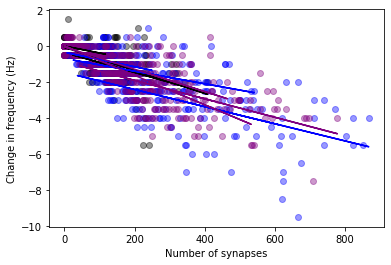

In [15]:
import numpy as np
import matplotlib.pyplot as plt
cs = groups
for g in groups:
    for k in all_data[g]["experiment"]:
        x = list()
        y = list()
        for i in process_all_groups[g]["os"][k]:
            plt.scatter([process_all_groups[g]["os"][k][i]["num_synapses"]],[process_all_groups[g]["os"][k][i]["diff_Hz"]], c=cs[g],alpha=0.4)
            x.append(process_all_groups[g]["os"][k][i]["num_synapses"])
            y.append(process_all_groups[g]["os"][k][i]["diff_Hz"])
            if i in u:
                plt.scatter([process_all_groups[g]["us"][k][i]["num_synapses"]],[process_all_groups[g]["us"][k][i]["diff_Hz"]], c=cs[g],alpha=0.4)
        a, b = np.polyfit(x, y, 1)

        #add points to plot
        x = np.array(x)
        #add line of best fit to plot
        plt.plot(x, a*x+b, c=cs[g])
plt.xlabel("Number of synapses")
plt.ylabel("Change in frequency (Hz)")
plt.savefig("Num_synapse_Frequency.svg")

In [22]:
synapse_groups = dict()

In [23]:
import os
for g in groups:
    tmp = dict()
    with h5py.File(os.path.join("synapses_frequency",f"{g}_synapses.h5"), "r") as sf:
        for r in sf:
            for s in [*os[e].keys()]:
            tmp.update({r: sf[r][:]})
            
    synapse_groups.update({g: tmp})

In [44]:
%%time
all_presynaptic_groups = dict()
for g in groups:
    e_tmps = dict()
    print(g)
    for k in all_data[g]["experiment"]:
        print(k)
        tmps = list()
        synapses = synapse_groups[g][k]
        for s in [*process_all_groups[g]["os"][k].keys()][:10]:
            presynaptic = np.where(synapses.T[1] == s)


            tmps.append(len(presynaptic[0]))
        e_tmps.update({k: tmps})   
        
    all_presynaptic_groups.update({g: e_tmps})
        
    

        


distance
0
45
90
complete_network
p0125
p025
p05
distance_complete
0
45
90
CPU times: user 24.4 s, sys: 57.1 s, total: 1min 21s
Wall time: 6min 9s


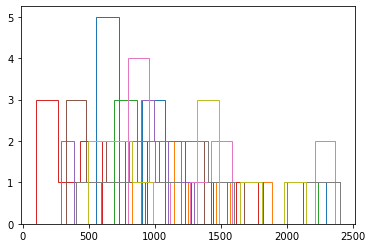

In [45]:
for g in groups:
    for e in all_presynaptic_groups[g]:
        plt.hist(all_presynaptic_groups[g][e],histtype="step")

In [51]:
%%time
threshold = 1500
all_presynaptic_groups = dict()
for g in groups:
    print(g)
    e_tmps = dict()
    for k in all_data[g]["experiment"]:
        print(k)
        tmps = list()
        synapses = synapse_groups[g][k]
        for s in [*process_all_groups[g]["os"][k].keys()]:
            presynaptic = np.where(synapses.T[1] == s)
            if len(presynaptic[0]) > threshold:
                tmps.append(s)
        e_tmps.update({k: tmps})   
        
    all_presynaptic_groups.update({g: e_tmps})     
    
        


distance
0
45
90
complete_network
p0125
p025
p05
distance_complete
0
45
90
CPU times: user 3min 22s, sys: 1min 9s, total: 4min 32s
Wall time: 11min 12s


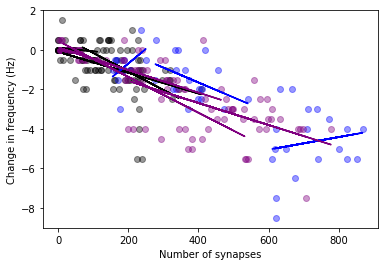

In [55]:
import numpy as np
import matplotlib.pyplot as plt
cs = groups
for g in groups:
    for k in all_data[g]["experiment"]:
        x = list()
        y = list()
        for i in all_presynaptic_groups[g][k]:
            plt.scatter([process_all_groups[g]["os"][k][i]["num_synapses"]],[process_all_groups[g]["os"][k][i]["diff_Hz"]], c=cs[g],alpha=0.4)
            x.append(process_all_groups[g]["os"][k][i]["num_synapses"])
            y.append(process_all_groups[g]["os"][k][i]["diff_Hz"])
            if i in u:
                plt.scatter([process_all_groups[g]["us"][k][i]["num_synapses"]],[process_all_groups[g]["us"][k][i]["diff_Hz"]], c=cs[g],alpha=0.4)
        a, b = np.polyfit(x, y, 1)

        #add points to plot
        x = np.array(x)
        #add line of best fit to plot
        plt.plot(x, a*x+b, c=cs[g])
plt.xlabel("Number of synapses")
plt.ylabel("Change in frequency (Hz)")
plt.savefig("Num_synapse_Frequency.svg")

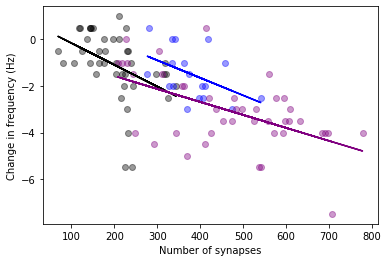

In [54]:
import numpy as np
import matplotlib.pyplot as plt
cs = groups
for g in groups:
    for k in all_data[g]["experiment"]:
        if k in ["0","p025"]:
            x = list()
            y = list()
            for i in all_presynaptic_groups[g][k]:
                plt.scatter([process_all_groups[g]["os"][k][i]["num_synapses"]],[process_all_groups[g]["os"][k][i]["diff_Hz"]], c=cs[g],alpha=0.4)
                x.append(process_all_groups[g]["os"][k][i]["num_synapses"])
                y.append(process_all_groups[g]["os"][k][i]["diff_Hz"])
                if i in u:
                    plt.scatter([process_all_groups[g]["us"][k][i]["num_synapses"]],[process_all_groups[g]["us"][k][i]["diff_Hz"]], c=cs[g],alpha=0.4)
            a, b = np.polyfit(x, y, 1)

            #add points to plot
            x = np.array(x)
            #add line of best fit to plot
            plt.plot(x, a*x+b, c=cs[g])
plt.xlabel("Number of synapses")
plt.ylabel("Change in frequency (Hz)")
plt.savefig("Num_synapse_Frequency_comparables.svg")